In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentence_transformers

     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 3.8 MB 40.6 MB/s 
     |████████████████████████████████| 1.2 MB 54.3 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 43.8 MB/s 
     |████████████████████████████████| 596 kB 62.6 MB/s 
     |████████████████████████████████| 6.5 MB 21.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=b5ae4bfc7bd5b4e01b76e294ba74d9531a2409a13c2a43c8db05469f1522ba0e
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import spacy
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score
#from sklearn.metrics import classification_report
import pickle

In [4]:
#Reading csv file
train = pd.read_csv("/content/drive/MyDrive/DL_DialogDataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DL_DialogDataset/test.csv")
train

,utterance,act
0,"Say , Jim , how about going for a few beers af...",3
1,You know that is tempting but is really not g...,4
2,What do you mean ? It will help us to relax .,2
3,Do you really think so ? I don't . It will ju...,2
4,I guess you are right.But what shall we do ? ...,2
...,...,...
5085,Tom and Helen got married at last .,1
5086,How did you know that ? I heart Tom ’ s fathe...,2
5087,I was invited to attend their wedding .,1
5088,It ’ s great . Although his father didn ’ t a...,1


In [5]:
Xtrain = train.utterance
ytrain = train.act - 1 
Xtest = test.utterance
ytest = test.act - 1
  

In [6]:
Xtrain

0       Say , Jim , how about going for a few beers af...
1        You know that is tempting but is really not g...
2          What do you mean ? It will help us to relax . 
3        Do you really think so ? I don't . It will ju...
4        I guess you are right.But what shall we do ? ...
                              ...                        
5085                 Tom and Helen got married at last . 
5086     How did you know that ? I heart Tom ’ s fathe...
5087             I was invited to attend their wedding . 
5088     It ’ s great . Although his father didn ’ t a...
5089                                How moving love is . 
Name: utterance, Length: 5090, dtype: object

In [116]:
np.random.seed(0)
torch.manual_seed(0)
# random.seed(0)

## Data Visualization

In [7]:
!pip install wordcloud

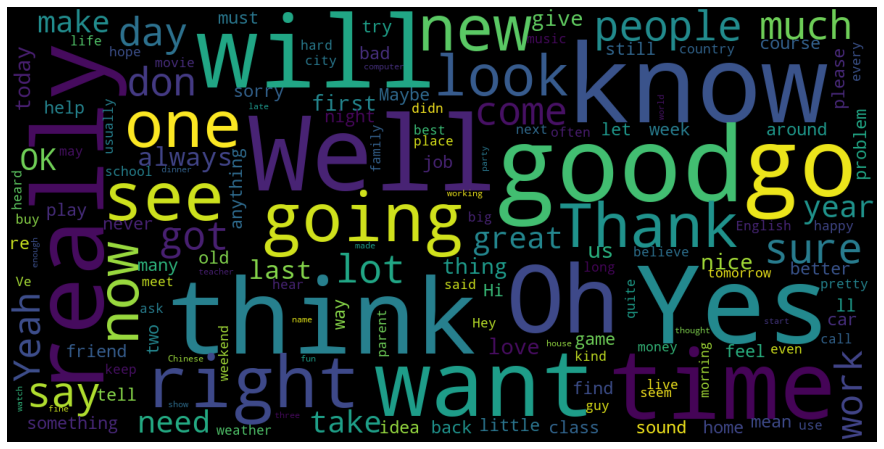

In [8]:
from wordcloud import WordCloud
# Display the world cloud
data = ' '.join(text for text in train['utterance'])
world_cloud = WordCloud(background_color='black',max_words=150,max_font_size=50,scale=3,random_state=1, collocations=False).generate(data)
plt.figure(figsize = (100,8))
plt.axis('off')
plt.imshow(world_cloud)

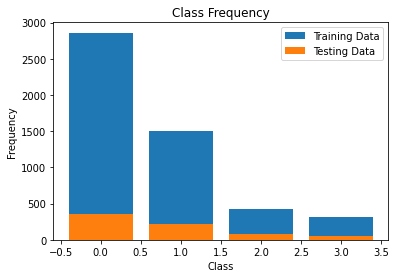

In [67]:

unique, counts = np.unique(ytrain, return_counts=True)
plt.bar(unique, counts,label="Training Data")
unique, counts = np.unique(ytest, return_counts=True)
plt.bar(unique, counts,label="Testing Data")
plt.legend()

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

## Preprocessing

In [9]:
!pip install contractions 

     |████████████████████████████████| 287 kB 22.7 MB/s 
     |████████████████████████████████| 106 kB 62.8 MB/s 


In [10]:
# Xtrain2 = []
# ytrain2 = []
# Xtest2 = []
# ytest2 = []
# for i in tqdm(range(0, len(Xtrain))):
#     newStr = ""
#     # Xtrain2.append( Xtrain[i-4] + ' '+Xtrain[i-3] + ' '+Xtrain[i-2] + ' '+Xtrain[i-1] + ' ' + Xtrain[i])
#     # Xtrain2.append(Xtrain[i-2] + ' '+Xtrain[i-1] + ' ' + Xtrain[i])
#     # Xtrain2.append(Xtrain[i-1] + ' ' + Xtrain[i])
#     Xtrain2.append(Xtrain[i])
#     ytrain2.append(ytrain[i])
# # for i in tqdm(range(1, len(Xtest))):
# #     Xtest2.append(Xtest[i-1] + ' ' + Xtest[i])
# #     ytest2.append(ytest[i])

# max_seq_len = len(max(Xtrain2, key=len))

In [11]:

def lowerCase(df):
  for i in range(len(df)):
    df[i] = df[i].lower()
  return df


In [12]:
import contractions

def contractionExpand(df):
  for i in range(len(df)):
    df[i] = contractions.fix(df[i])
  return df
  # return contractions.fix(text)


In [13]:
import nltk
nltk.download('punkt')

def tokenize(df):
  for i in range(len(df)):
    df[i] = nltk.word_tokenize(df[i])
  return df
 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
Xtrain

0       Say , Jim , how about going for a few beers af...
1        You know that is tempting but is really not g...
2          What do you mean ? It will help us to relax . 
3        Do you really think so ? I don't . It will ju...
4        I guess you are right.But what shall we do ? ...
                              ...                        
5085                 Tom and Helen got married at last . 
5086     How did you know that ? I heart Tom ’ s fathe...
5087             I was invited to attend their wedding . 
5088     It ’ s great . Although his father didn ’ t a...
5089                                How moving love is . 
Name: utterance, Length: 5090, dtype: object

In [15]:
Xtest

0                 I'm better now . Want to play again ? 
1              I'll let you break the balls this time . 
2          Let's get all the balls out of the pockets . 
3       OK . How much do you want to bet on this game ? 
4       You are crazy . Gambling is against my princi...
                             ...                        
717     Yeah , I got to eat as much pizza as I could ...
718                             Did you like the play ? 
719     Not really . It's a dull one , and the produc...
720     You're absolutely right . The acting could be...
721     To be fair , though , both the costumes and s...
Name: utterance, Length: 722, dtype: object

In [16]:
def preprocessing(x):
  x = lowerCase(x)
  x = contractionExpand(x)
  x = tokenize(x)
  return x

Xtrain = preprocessing(Xtrain)
Xtest = preprocessing(Xtest)





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
# max_seq_len = len(max(Xtrain, key=len))
# max_seq_len = len(max(Xtrain2, key=len))

### Sentence Embedding for each utterance: Using Bert sentence transformer

In [18]:
Xtrain = [[' '.join(i)] for i in Xtrain]
Xtrain = [i[0] for i in Xtrain]
Xtest = [[' '.join(i)] for i in Xtest]
Xtest = [i[0] for i in Xtest]

In [19]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
train_sentence_embeddings = sbert_model.encode(Xtrain)
test_sentence_embeddings = sbert_model.encode(Xtest)

In [21]:
train_sentence_embeddings.shape, test_sentence_embeddings.shape

((5090, 768), (722, 768))

In [22]:
test_sentence_embeddings = np.array(test_sentence_embeddings)

In [23]:
# X = 5  #x-1 prev utterances
def prep_data(X):
  Xtrain_context = np.zeros((len(train_sentence_embeddings)-X+1,X,train_sentence_embeddings.shape[1]))

  for i in range(len(train_sentence_embeddings)-X-1):
    k = 0
    for j in range(i,i+X):
      Xtrain_context[i][k] = train_sentence_embeddings[j]
      # Xtrain_context[i][k] = Xtrain_context[i][k].astype('int')
      # Xtrain_context[i][k] = [int(l) for l in Xtrain_context[i][k]]
      k+=1

  Xtest_context = np.zeros((len(test_sentence_embeddings)-X+1,X,test_sentence_embeddings.shape[1]))

  for i in range(len(test_sentence_embeddings)-X-1):
    k = 0
    for j in range(i,i+X):
      Xtest_context[i][k] = test_sentence_embeddings[j]
      # Xtrain_context[i][k] = Xtrain_context[i][k].astype('int')
      # Xtrain_context[i][k] = [int(l) for l in Xtrain_context[i][k]]
      k+=1

  # Xtrain_context = Xtrain_context.astype('int')
  ytrain_context = np.array(ytrain)
  ytrain_context = ytrain_context[X-1:]
  train_data = TensorDataset(torch.from_numpy(Xtrain_context), torch.from_numpy(ytrain_context))
  trainDataLoader = DataLoader(train_data,batch_size=32)
  ytest_context = np.array(ytest)
  ytest_context = ytest_context[X-1:]
  test_data = TensorDataset(torch.from_numpy(Xtest_context), torch.from_numpy(ytest_context))
  testDataLoader = DataLoader(test_data, batch_size=32)
  return trainDataLoader,testDataLoader, ytest_context




In [24]:
test_sentence_embeddings = np.array(test_sentence_embeddings)
# Xtest_id= np.vstack(Xtest_id).astype('int')
ytest = np.array(ytest)
test_data = TensorDataset(torch.from_numpy(test_sentence_embeddings), torch.from_numpy(ytest))

In [25]:
testDataLoader = DataLoader(test_data, batch_size=32)

In [26]:
class LSTMClass(nn.Module):
    def __init__(self,embedding_dim,hidden_size,num_layers,drop_prob):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        # print(embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True,bidirectional=False)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_size, 4)
        # self.softmax = nn.Softmax()
        

    def forward(self, x):
      # print(x.shape)
      hnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      cnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      out,_ = self.lstm(x,(hnot,cnot))
      out = out[:,-1,:]
      # print("lstm",out.shape)
      out = self.dropout(out)
      out = self.linear(out)
      # print("lin",out.shape)
      # out = self.softmax(out)
      return out

In [27]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)

In [28]:
def lossVsEpochPlot(Loss,color,label):
    """
    Plot the loss vs epoch plot
    trainLoss: train loss
    validLoss: test loss
    """
    plt.plot(Loss, color=color)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(label+" Loss")
    plt.title(label+ " Loss vs Epochs Plot")
#     plt.savefig("Plots/Ques2/part1/{}_lossVsEpochs.png".format(funtion))
    plt.show()


def accVsEpochPlot(trainAcc, testAcc):
    """
    Plot the accuracy vs epoch plot
    trainAcc: train accuracy
    validAcc: test accuracy
    """
    plt.plot(trainAcc, label="Train Accuracy", color="blue")
    plt.plot(testAcc, label="Test Accuracy", color="red")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs for ")
#     plt.savefig("Plots/Ques2/part1/{}_accVsEpochs.png".format(funtion))
    plt.show()

In [38]:
def AccReport(dataloader,flag):
  with torch.no_grad():
      nCorrect = 0
      nSamples = 0
      nClassCorrect = [0 for i in range(4)]
      nClassTotal = [0 for i in range(4)]
      yPred = []
     
          
      for i,data in tqdm(enumerate(dataloader)):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          # print("l",labels.shape)
          # print(labels)
          labels = labels.reshape((-1,)).to(device)
          # if(flag):
          #   inputs = torch.unsqueeze(inputs,1)
          # print("l",labels.shape)
          # print(labels)
          
          outputs = lstm(inputs.float())
          loss = criterion(outputs, labels)
          # outputs = torch.squeeze(outputs)
          # outputs = outputs.reshape((-1, 1))
          # print(outputs.shape)
          _, predictions = torch.max(outputs,1)
          # print(predictions)
          # print("l",labels)
          nSamples += labels.shape[0]
          # nCorrect += (predictions == labels).sum().item()
          for i in range(len(predictions)):
            if predictions[i] == labels[i]:
              nCorrect += 1
            yPred.append(predictions[i])
           

            



      
      acc = 100.0 * nCorrect / nSamples
      if(flag):
        print(f'Accuracy on test: {acc:.2f}')
      else:
        print(f'Accuracy on train: {acc:.2f}')
      return acc,yPred

    

In [41]:
def training(X):
  trainDataLoader,testDataLoader,ytest = prep_data(X)
  totalSteps = len(trainDataLoader)
  numEpochs = 5
  trainLossAll = []
  trainAccAll = []
  valLossAll = []
  valAccAll = []
  # X = 2  # X previous utterances for t th utterance


  for epoch in range(numEpochs):  # loop over the dataset multiple times

      running_loss = 0.0
      trainLoss = 0
      
      for i, data in tqdm(enumerate(trainDataLoader)):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          # print("l",labels.shape)
          # print(labels)
          labels = labels.reshape((-1,)).to(device)
          # print("l",labels.shape)
          # print(labels)
          # inputs = torch.squeeze(inputs,0)
          # print(inputs.shape)
          # print(inputs)
          # print(inputs.float().shape)
          outputs = lstm(inputs.float())
          
            
          # outputs = torch.squeeze(outputs)
          # outputs = outputs.reshape((-1, 1))
          # print(outputs.shape)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          trainLoss += loss.item()*inputs.size(0)
      
          lstm.eval()
          validLoss = 0
          for data, target in testDataLoader:
              data, target = data.to(device), target.to(device)
              # data = torch.unsqueeze(data,1)
              # print(data.shape)
              output = lstm(data.float())
              # print(target)
              loss = criterion(output, target)
              validLoss += loss.item()*data.size(0)
          
    

      
          if (i+1) % 10 == 0:
              print(f'Epoch {epoch + 1} / {numEpochs}, Step {i+1} / {totalSteps}, Loss: {loss.item():.4f}')
              # print(outputs)

      trainLoss = trainLoss/len(trainDataLoader.dataset)
      validLoss = validLoss/len(testDataLoader.dataset)
          
      trainAcc,f1Train = AccReport(trainDataLoader,False)
      trainLossAll.append(trainLoss)
      trainAccAll.append(trainAcc)
      valAcc,f1Val = AccReport(testDataLoader,True)
      valLossAll.append(validLoss)
      valAccAll.append(valAcc)


  print('Finished Training')
  return trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest

In [72]:
def finalReport(ytest,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll):
  lossVsEpochPlot(trainLossAll, "blue","Training")
  lossVsEpochPlot(valLossAll, "red","Validation")
  trainAcc,yPred = AccReport(trainDataLoader,False)
  testAcc,yPred = AccReport(testDataLoader,True)
  accVsEpochPlot(trainAccAll, valAccAll)
  f1 = f1_score(ytest, yPred, average='weighted')
  print(f'fl score on test: {f1:.2f}')
  print(classification_report(ytest, yPred)) 
  testMaxAcc = max(valAccAll)
  max_i = valAccAll.index(testMaxAcc)
  trainMaxVal = trainAccAll[max_i]
  X_f1.append(f1)
  X_valacc.append(testAcc)
  X_trainacc.append(trainMaxVal)
  X_valMaxacc.append(testMaxAcc)
  return testAcc,f1



In [115]:
def modelSave(model,fileName):
  with open(fileName, 'wb') as file:
      
    # A new file will be created
    pickle.dump(model, file)

def modelLoad(model,fileName):
  with open('file016.pkl', 'rb') as f:
    model = pickle.load(f)
  return model

In [117]:
X_valacc = []
X_valMaxacc = []
X_trainacc = []
X_f1 = []

## X = 0

In [118]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(1)

18it [00:00, 50.22it/s]

Epoch 1 / 5, Step 10 / 160, Loss: 1.2294


30it [00:00, 51.18it/s]

Epoch 1 / 5, Step 20 / 160, Loss: 1.0884
Epoch 1 / 5, Step 30 / 160, Loss: 1.0035


48it [00:00, 51.26it/s]

Epoch 1 / 5, Step 40 / 160, Loss: 0.9303
Epoch 1 / 5, Step 50 / 160, Loss: 0.8448


66it [00:01, 52.17it/s]

Epoch 1 / 5, Step 60 / 160, Loss: 0.7414
Epoch 1 / 5, Step 70 / 160, Loss: 0.6551


90it [00:01, 51.74it/s]

Epoch 1 / 5, Step 80 / 160, Loss: 0.5721
Epoch 1 / 5, Step 90 / 160, Loss: 0.5503


108it [00:02, 51.60it/s]

Epoch 1 / 5, Step 100 / 160, Loss: 0.5254
Epoch 1 / 5, Step 110 / 160, Loss: 0.4970


126it [00:02, 51.44it/s]

Epoch 1 / 5, Step 120 / 160, Loss: 0.5310
Epoch 1 / 5, Step 130 / 160, Loss: 0.4728


150it [00:02, 51.82it/s]

Epoch 1 / 5, Step 140 / 160, Loss: 0.4770
Epoch 1 / 5, Step 150 / 160, Loss: 0.4917


160it [00:03, 51.37it/s]


Epoch 1 / 5, Step 160 / 160, Loss: 0.4612


160it [00:00, 960.12it/s]


Accuracy on train: 76.15


23it [00:00, 846.14it/s]


Accuracy on test: 71.33


6it [00:00, 52.27it/s]

Epoch 2 / 5, Step 10 / 160, Loss: 0.4503


18it [00:00, 51.73it/s]

Epoch 2 / 5, Step 20 / 160, Loss: 0.4385


36it [00:00, 50.67it/s]

Epoch 2 / 5, Step 30 / 160, Loss: 0.4089
Epoch 2 / 5, Step 40 / 160, Loss: 0.3827


60it [00:01, 51.88it/s]

Epoch 2 / 5, Step 50 / 160, Loss: 0.3798
Epoch 2 / 5, Step 60 / 160, Loss: 0.3818


78it [00:01, 51.00it/s]

Epoch 2 / 5, Step 70 / 160, Loss: 0.3708


90it [00:01, 51.06it/s]

Epoch 2 / 5, Step 80 / 160, Loss: 0.3660
Epoch 2 / 5, Step 90 / 160, Loss: 0.3827


107it [00:02, 49.75it/s]

Epoch 2 / 5, Step 100 / 160, Loss: 0.3938
Epoch 2 / 5, Step 110 / 160, Loss: 0.3926


125it [00:02, 50.11it/s]

Epoch 2 / 5, Step 120 / 160, Loss: 0.4366
Epoch 2 / 5, Step 130 / 160, Loss: 0.4097


149it [00:02, 51.95it/s]

Epoch 2 / 5, Step 140 / 160, Loss: 0.4125
Epoch 2 / 5, Step 150 / 160, Loss: 0.4238


160it [00:03, 51.04it/s]


Epoch 2 / 5, Step 160 / 160, Loss: 0.4062


160it [00:00, 917.47it/s]


Accuracy on train: 80.59


23it [00:00, 793.78it/s]


Accuracy on test: 73.68


18it [00:00, 50.99it/s]

Epoch 3 / 5, Step 10 / 160, Loss: 0.4105
Epoch 3 / 5, Step 20 / 160, Loss: 0.4041


36it [00:00, 49.81it/s]

Epoch 3 / 5, Step 30 / 160, Loss: 0.3819


47it [00:00, 50.32it/s]

Epoch 3 / 5, Step 40 / 160, Loss: 0.3621
Epoch 3 / 5, Step 50 / 160, Loss: 0.3639


65it [00:01, 50.89it/s]

Epoch 3 / 5, Step 60 / 160, Loss: 0.3697
Epoch 3 / 5, Step 70 / 160, Loss: 0.3660


89it [00:01, 51.12it/s]

Epoch 3 / 5, Step 80 / 160, Loss: 0.3643
Epoch 3 / 5, Step 90 / 160, Loss: 0.3854


107it [00:02, 51.12it/s]

Epoch 3 / 5, Step 100 / 160, Loss: 0.3946


119it [00:02, 50.28it/s]

Epoch 3 / 5, Step 110 / 160, Loss: 0.3961
Epoch 3 / 5, Step 120 / 160, Loss: 0.4464


137it [00:02, 50.66it/s]

Epoch 3 / 5, Step 130 / 160, Loss: 0.4179


149it [00:02, 51.00it/s]

Epoch 3 / 5, Step 140 / 160, Loss: 0.4051
Epoch 3 / 5, Step 150 / 160, Loss: 0.4199


160it [00:03, 50.54it/s]


Epoch 3 / 5, Step 160 / 160, Loss: 0.4062


160it [00:00, 913.78it/s]


Accuracy on train: 83.01


23it [00:00, 767.30it/s]


Accuracy on test: 73.82


18it [00:00, 52.58it/s]

Epoch 4 / 5, Step 10 / 160, Loss: 0.4290
Epoch 4 / 5, Step 20 / 160, Loss: 0.4214


36it [00:00, 51.32it/s]

Epoch 4 / 5, Step 30 / 160, Loss: 0.3891
Epoch 4 / 5, Step 40 / 160, Loss: 0.3708


60it [00:01, 52.22it/s]

Epoch 4 / 5, Step 50 / 160, Loss: 0.3776
Epoch 4 / 5, Step 60 / 160, Loss: 0.3819


78it [00:01, 52.33it/s]

Epoch 4 / 5, Step 70 / 160, Loss: 0.3836
Epoch 4 / 5, Step 80 / 160, Loss: 0.3846


96it [00:01, 50.78it/s]

Epoch 4 / 5, Step 90 / 160, Loss: 0.4036
Epoch 4 / 5, Step 100 / 160, Loss: 0.4007


120it [00:02, 52.36it/s]

Epoch 4 / 5, Step 110 / 160, Loss: 0.4004
Epoch 4 / 5, Step 120 / 160, Loss: 0.4645


138it [00:02, 52.37it/s]

Epoch 4 / 5, Step 130 / 160, Loss: 0.4306
Epoch 4 / 5, Step 140 / 160, Loss: 0.4103


160it [00:03, 51.28it/s]


Epoch 4 / 5, Step 150 / 160, Loss: 0.4215
Epoch 4 / 5, Step 160 / 160, Loss: 0.4129


160it [00:00, 945.65it/s]


Accuracy on train: 85.62


23it [00:00, 841.50it/s]


Accuracy on test: 75.21


18it [00:00, 51.28it/s]

Epoch 5 / 5, Step 10 / 160, Loss: 0.4526


24it [00:00, 50.42it/s]

Epoch 5 / 5, Step 20 / 160, Loss: 0.4394


35it [00:00, 49.33it/s]

Epoch 5 / 5, Step 30 / 160, Loss: 0.3959
Epoch 5 / 5, Step 40 / 160, Loss: 0.3814


59it [00:01, 51.48it/s]

Epoch 5 / 5, Step 50 / 160, Loss: 0.3906
Epoch 5 / 5, Step 60 / 160, Loss: 0.3937


77it [00:01, 51.33it/s]

Epoch 5 / 5, Step 70 / 160, Loss: 0.3953


89it [00:01, 49.92it/s]

Epoch 5 / 5, Step 80 / 160, Loss: 0.3966
Epoch 5 / 5, Step 90 / 160, Loss: 0.4151


107it [00:02, 47.88it/s]

Epoch 5 / 5, Step 100 / 160, Loss: 0.4013


117it [00:02, 47.32it/s]

Epoch 5 / 5, Step 110 / 160, Loss: 0.3951


128it [00:02, 47.42it/s]

Epoch 5 / 5, Step 120 / 160, Loss: 0.4719


139it [00:02, 48.81it/s]

Epoch 5 / 5, Step 130 / 160, Loss: 0.4364
Epoch 5 / 5, Step 140 / 160, Loss: 0.4179


160it [00:03, 49.76it/s]


Epoch 5 / 5, Step 150 / 160, Loss: 0.4224
Epoch 5 / 5, Step 160 / 160, Loss: 0.4065


160it [00:00, 936.99it/s]


Accuracy on train: 87.47


23it [00:00, 685.19it/s]

Accuracy on test: 75.76
Finished Training


In [119]:
modelSave(lstm,"X0")

No handles with labels found to put in legend.


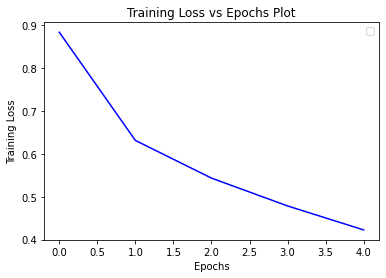

No handles with labels found to put in legend.


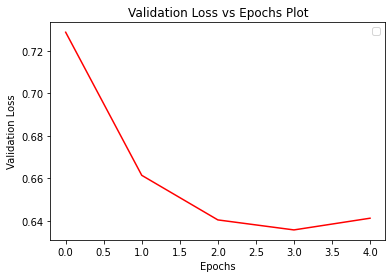

160it [00:00, 962.81it/s] 


Accuracy on train: 87.47


23it [00:00, 825.95it/s]


Accuracy on test: 75.76


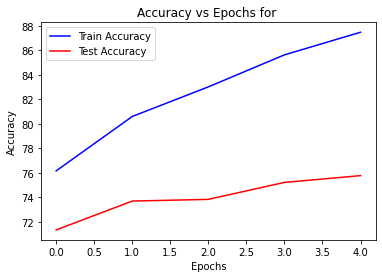

fl score on test: 0.75
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       363
           1       0.82      0.82      0.82       217
           2       0.61      0.41      0.49        83
           3       0.50      0.37      0.43        59

    accuracy                           0.76       722
   macro avg       0.67      0.62      0.64       722
weighted avg       0.75      0.76      0.75       722



In [120]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

## X = 1

In [121]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(2)

16it [00:00, 37.31it/s]

Epoch 1 / 5, Step 10 / 160, Loss: 1.2485


24it [00:00, 36.30it/s]

Epoch 1 / 5, Step 20 / 160, Loss: 1.1494


36it [00:00, 36.80it/s]

Epoch 1 / 5, Step 30 / 160, Loss: 1.0493


44it [00:01, 36.07it/s]

Epoch 1 / 5, Step 40 / 160, Loss: 0.9879


56it [00:01, 35.11it/s]

Epoch 1 / 5, Step 50 / 160, Loss: 0.9288


64it [00:01, 34.64it/s]

Epoch 1 / 5, Step 60 / 160, Loss: 0.8111


76it [00:02, 36.06it/s]

Epoch 1 / 5, Step 70 / 160, Loss: 0.6927


84it [00:02, 34.32it/s]

Epoch 1 / 5, Step 80 / 160, Loss: 0.6412


96it [00:02, 36.34it/s]

Epoch 1 / 5, Step 90 / 160, Loss: 0.5867


104it [00:02, 35.52it/s]

Epoch 1 / 5, Step 100 / 160, Loss: 0.5611


116it [00:03, 36.44it/s]

Epoch 1 / 5, Step 110 / 160, Loss: 0.5130


124it [00:03, 36.28it/s]

Epoch 1 / 5, Step 120 / 160, Loss: 0.5358


136it [00:03, 35.98it/s]

Epoch 1 / 5, Step 130 / 160, Loss: 0.4594


144it [00:04, 35.78it/s]

Epoch 1 / 5, Step 140 / 160, Loss: 0.4516


156it [00:04, 35.15it/s]

Epoch 1 / 5, Step 150 / 160, Loss: 0.4513


160it [00:04, 35.65it/s]


Epoch 1 / 5, Step 160 / 160, Loss: 0.3800


160it [00:00, 708.01it/s]


Accuracy on train: 77.13


23it [00:00, 550.96it/s]


Accuracy on test: 72.40


16it [00:00, 37.71it/s]

Epoch 2 / 5, Step 10 / 160, Loss: 0.3948


24it [00:00, 36.08it/s]

Epoch 2 / 5, Step 20 / 160, Loss: 0.3884


36it [00:00, 36.97it/s]

Epoch 2 / 5, Step 30 / 160, Loss: 0.3395


44it [00:01, 35.96it/s]

Epoch 2 / 5, Step 40 / 160, Loss: 0.3331


56it [00:01, 35.45it/s]

Epoch 2 / 5, Step 50 / 160, Loss: 0.3341


64it [00:01, 35.18it/s]

Epoch 2 / 5, Step 60 / 160, Loss: 0.3317


76it [00:02, 36.03it/s]

Epoch 2 / 5, Step 70 / 160, Loss: 0.2870


84it [00:02, 36.49it/s]

Epoch 2 / 5, Step 80 / 160, Loss: 0.2947


96it [00:02, 35.75it/s]

Epoch 2 / 5, Step 90 / 160, Loss: 0.2973


104it [00:02, 35.99it/s]

Epoch 2 / 5, Step 100 / 160, Loss: 0.3079


116it [00:03, 36.55it/s]

Epoch 2 / 5, Step 110 / 160, Loss: 0.2995


124it [00:03, 34.53it/s]

Epoch 2 / 5, Step 120 / 160, Loss: 0.3426


136it [00:03, 36.00it/s]

Epoch 2 / 5, Step 130 / 160, Loss: 0.3161


144it [00:04, 35.61it/s]

Epoch 2 / 5, Step 140 / 160, Loss: 0.3229


156it [00:04, 35.91it/s]

Epoch 2 / 5, Step 150 / 160, Loss: 0.3171


160it [00:04, 35.81it/s]


Epoch 2 / 5, Step 160 / 160, Loss: 0.2635


160it [00:00, 705.87it/s]


Accuracy on train: 82.35


23it [00:00, 572.65it/s]


Accuracy on test: 75.87


16it [00:00, 36.48it/s]

Epoch 3 / 5, Step 10 / 160, Loss: 0.2765


24it [00:00, 35.44it/s]

Epoch 3 / 5, Step 20 / 160, Loss: 0.2817


36it [00:01, 35.70it/s]

Epoch 3 / 5, Step 30 / 160, Loss: 0.2443


44it [00:01, 36.12it/s]

Epoch 3 / 5, Step 40 / 160, Loss: 0.2273


56it [00:01, 35.86it/s]

Epoch 3 / 5, Step 50 / 160, Loss: 0.2442


64it [00:01, 34.80it/s]

Epoch 3 / 5, Step 60 / 160, Loss: 0.2458


76it [00:02, 35.95it/s]

Epoch 3 / 5, Step 70 / 160, Loss: 0.2115


84it [00:02, 36.14it/s]

Epoch 3 / 5, Step 80 / 160, Loss: 0.2286


96it [00:02, 35.62it/s]

Epoch 3 / 5, Step 90 / 160, Loss: 0.2281


104it [00:02, 35.99it/s]

Epoch 3 / 5, Step 100 / 160, Loss: 0.2254


116it [00:03, 34.98it/s]

Epoch 3 / 5, Step 110 / 160, Loss: 0.2235


124it [00:03, 35.28it/s]

Epoch 3 / 5, Step 120 / 160, Loss: 0.2529


136it [00:03, 35.98it/s]

Epoch 3 / 5, Step 130 / 160, Loss: 0.2510


144it [00:04, 35.42it/s]

Epoch 3 / 5, Step 140 / 160, Loss: 0.2866


156it [00:04, 36.03it/s]

Epoch 3 / 5, Step 150 / 160, Loss: 0.2690


160it [00:04, 35.65it/s]


Epoch 3 / 5, Step 160 / 160, Loss: 0.2118


160it [00:00, 681.02it/s]


Accuracy on train: 86.11


23it [00:00, 657.85it/s]


Accuracy on test: 76.98


16it [00:00, 36.05it/s]

Epoch 4 / 5, Step 10 / 160, Loss: 0.2186


24it [00:00, 36.27it/s]

Epoch 4 / 5, Step 20 / 160, Loss: 0.2205


36it [00:01, 35.64it/s]

Epoch 4 / 5, Step 30 / 160, Loss: 0.2060


44it [00:01, 35.77it/s]

Epoch 4 / 5, Step 40 / 160, Loss: 0.1835


56it [00:01, 35.52it/s]

Epoch 4 / 5, Step 50 / 160, Loss: 0.2101


64it [00:01, 35.84it/s]

Epoch 4 / 5, Step 60 / 160, Loss: 0.2070


76it [00:02, 35.86it/s]

Epoch 4 / 5, Step 70 / 160, Loss: 0.1749


84it [00:02, 35.56it/s]

Epoch 4 / 5, Step 80 / 160, Loss: 0.1893


96it [00:02, 36.65it/s]

Epoch 4 / 5, Step 90 / 160, Loss: 0.2039


104it [00:02, 36.47it/s]

Epoch 4 / 5, Step 100 / 160, Loss: 0.1941


116it [00:03, 36.56it/s]

Epoch 4 / 5, Step 110 / 160, Loss: 0.1955


124it [00:03, 35.90it/s]

Epoch 4 / 5, Step 120 / 160, Loss: 0.2148


136it [00:03, 35.48it/s]

Epoch 4 / 5, Step 130 / 160, Loss: 0.2286


144it [00:04, 35.99it/s]

Epoch 4 / 5, Step 140 / 160, Loss: 0.2890


152it [00:04, 35.98it/s]

Epoch 4 / 5, Step 150 / 160, Loss: 0.2663


160it [00:05, 30.53it/s]


Epoch 4 / 5, Step 160 / 160, Loss: 0.2015


160it [00:00, 709.04it/s]


Accuracy on train: 89.33


23it [00:00, 686.78it/s]


Accuracy on test: 75.87


12it [00:01, 10.38it/s]

Epoch 5 / 5, Step 10 / 160, Loss: 0.1986


24it [00:01, 23.19it/s]

Epoch 5 / 5, Step 20 / 160, Loss: 0.2009


36it [00:01, 29.67it/s]

Epoch 5 / 5, Step 30 / 160, Loss: 0.2045


44it [00:02, 31.81it/s]

Epoch 5 / 5, Step 40 / 160, Loss: 0.1948


56it [00:02, 33.84it/s]

Epoch 5 / 5, Step 50 / 160, Loss: 0.2100


64it [00:02, 35.18it/s]

Epoch 5 / 5, Step 60 / 160, Loss: 0.2043


76it [00:02, 35.67it/s]

Epoch 5 / 5, Step 70 / 160, Loss: 0.1552


84it [00:03, 36.30it/s]

Epoch 5 / 5, Step 80 / 160, Loss: 0.1631


96it [00:03, 36.32it/s]

Epoch 5 / 5, Step 90 / 160, Loss: 0.2035


104it [00:03, 36.48it/s]

Epoch 5 / 5, Step 100 / 160, Loss: 0.1903


116it [00:04, 36.64it/s]

Epoch 5 / 5, Step 110 / 160, Loss: 0.1939


124it [00:04, 35.13it/s]

Epoch 5 / 5, Step 120 / 160, Loss: 0.2053


136it [00:04, 36.12it/s]

Epoch 5 / 5, Step 130 / 160, Loss: 0.2240


144it [00:04, 35.82it/s]

Epoch 5 / 5, Step 140 / 160, Loss: 0.3114


156it [00:05, 35.44it/s]

Epoch 5 / 5, Step 150 / 160, Loss: 0.2921


160it [00:05, 30.33it/s]


Epoch 5 / 5, Step 160 / 160, Loss: 0.2314


160it [00:00, 700.47it/s]


Accuracy on train: 92.34


23it [00:00, 638.88it/s]

Accuracy on test: 76.42
Finished Training


In [122]:
modelSave(lstm,"X1")

No handles with labels found to put in legend.


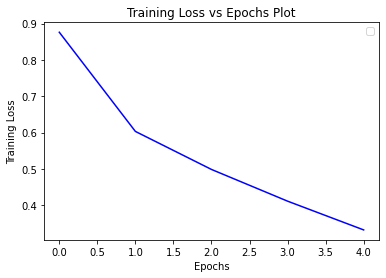

No handles with labels found to put in legend.


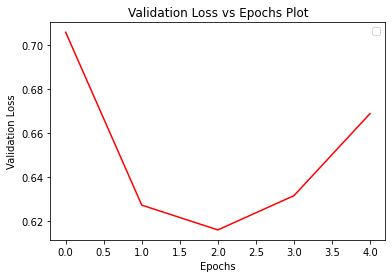

160it [00:00, 759.00it/s]


Accuracy on train: 92.34


23it [00:00, 596.68it/s]


Accuracy on test: 76.42


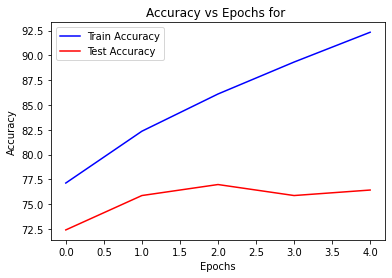

fl score on test: 0.76
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       363
           1       0.80      0.81      0.80       217
           2       0.63      0.45      0.52        82
           3       0.59      0.46      0.51        59

    accuracy                           0.76       721
   macro avg       0.70      0.64      0.67       721
weighted avg       0.76      0.76      0.76       721



In [123]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

## X = 2

In [124]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(3)

15it [00:00, 27.68it/s]

Epoch 1 / 5, Step 10 / 159, Loss: 1.2070


24it [00:00, 26.70it/s]

Epoch 1 / 5, Step 20 / 159, Loss: 0.9638


33it [00:01, 27.32it/s]

Epoch 1 / 5, Step 30 / 159, Loss: 0.8671


45it [00:01, 26.76it/s]

Epoch 1 / 5, Step 40 / 159, Loss: 0.8678


54it [00:01, 27.50it/s]

Epoch 1 / 5, Step 50 / 159, Loss: 0.7803


63it [00:02, 28.02it/s]

Epoch 1 / 5, Step 60 / 159, Loss: 0.6940


75it [00:02, 25.93it/s]

Epoch 1 / 5, Step 70 / 159, Loss: 0.6302


84it [00:03, 27.13it/s]

Epoch 1 / 5, Step 80 / 159, Loss: 0.5713


93it [00:03, 26.73it/s]

Epoch 1 / 5, Step 90 / 159, Loss: 0.5180


105it [00:03, 26.15it/s]

Epoch 1 / 5, Step 100 / 159, Loss: 0.4981


114it [00:04, 26.84it/s]

Epoch 1 / 5, Step 110 / 159, Loss: 0.4467


123it [00:04, 27.14it/s]

Epoch 1 / 5, Step 120 / 159, Loss: 0.4508


135it [00:05, 27.44it/s]

Epoch 1 / 5, Step 130 / 159, Loss: 0.4113


144it [00:05, 28.07it/s]

Epoch 1 / 5, Step 140 / 159, Loss: 0.4294


153it [00:05, 27.22it/s]

Epoch 1 / 5, Step 150 / 159, Loss: 0.4573


159it [00:05, 27.03it/s]
159it [00:00, 598.80it/s]


Accuracy on train: 76.00


23it [00:00, 439.09it/s]


Accuracy on test: 68.47


15it [00:00, 27.22it/s]

Epoch 2 / 5, Step 10 / 159, Loss: 0.4158


24it [00:00, 27.25it/s]

Epoch 2 / 5, Step 20 / 159, Loss: 0.3868


33it [00:01, 27.12it/s]

Epoch 2 / 5, Step 30 / 159, Loss: 0.3426


45it [00:01, 26.61it/s]

Epoch 2 / 5, Step 40 / 159, Loss: 0.3377


54it [00:02, 26.71it/s]

Epoch 2 / 5, Step 50 / 159, Loss: 0.3234


63it [00:02, 25.85it/s]

Epoch 2 / 5, Step 60 / 159, Loss: 0.3134


75it [00:02, 25.89it/s]

Epoch 2 / 5, Step 70 / 159, Loss: 0.3106


84it [00:03, 25.27it/s]

Epoch 2 / 5, Step 80 / 159, Loss: 0.3178


93it [00:03, 25.97it/s]

Epoch 2 / 5, Step 90 / 159, Loss: 0.3373


105it [00:03, 26.79it/s]

Epoch 2 / 5, Step 100 / 159, Loss: 0.3384


114it [00:04, 26.52it/s]

Epoch 2 / 5, Step 110 / 159, Loss: 0.3124


123it [00:04, 25.73it/s]

Epoch 2 / 5, Step 120 / 159, Loss: 0.3600


135it [00:05, 25.91it/s]

Epoch 2 / 5, Step 130 / 159, Loss: 0.3084


144it [00:05, 25.88it/s]

Epoch 2 / 5, Step 140 / 159, Loss: 0.3246


153it [00:05, 26.60it/s]

Epoch 2 / 5, Step 150 / 159, Loss: 0.3695


159it [00:06, 26.27it/s]
159it [00:00, 616.10it/s]


Accuracy on train: 81.70


23it [00:00, 527.75it/s]


Accuracy on test: 73.06


15it [00:00, 26.34it/s]

Epoch 3 / 5, Step 10 / 159, Loss: 0.3223


24it [00:00, 25.58it/s]

Epoch 3 / 5, Step 20 / 159, Loss: 0.3195


33it [00:01, 25.90it/s]

Epoch 3 / 5, Step 30 / 159, Loss: 0.2670


45it [00:01, 26.80it/s]

Epoch 3 / 5, Step 40 / 159, Loss: 0.2496


54it [00:02, 27.38it/s]

Epoch 3 / 5, Step 50 / 159, Loss: 0.2443


63it [00:02, 26.44it/s]

Epoch 3 / 5, Step 60 / 159, Loss: 0.2575


75it [00:02, 26.82it/s]

Epoch 3 / 5, Step 70 / 159, Loss: 0.2659


84it [00:03, 25.97it/s]

Epoch 3 / 5, Step 80 / 159, Loss: 0.3005


93it [00:03, 27.45it/s]

Epoch 3 / 5, Step 90 / 159, Loss: 0.3068


105it [00:03, 28.31it/s]

Epoch 3 / 5, Step 100 / 159, Loss: 0.2860


114it [00:04, 26.85it/s]

Epoch 3 / 5, Step 110 / 159, Loss: 0.2468


123it [00:04, 27.11it/s]

Epoch 3 / 5, Step 120 / 159, Loss: 0.2722


135it [00:05, 27.86it/s]

Epoch 3 / 5, Step 130 / 159, Loss: 0.2341


145it [00:05, 27.98it/s]

Epoch 3 / 5, Step 140 / 159, Loss: 0.2707


154it [00:05, 27.24it/s]

Epoch 3 / 5, Step 150 / 159, Loss: 0.3371


159it [00:05, 26.84it/s]
159it [00:00, 163.04it/s]


Accuracy on train: 85.77


23it [00:00, 482.18it/s]


Accuracy on test: 75.56


16it [00:00, 28.98it/s]

Epoch 4 / 5, Step 10 / 159, Loss: 0.2642


25it [00:00, 28.63it/s]

Epoch 4 / 5, Step 20 / 159, Loss: 0.2827


34it [00:01, 27.53it/s]

Epoch 4 / 5, Step 30 / 159, Loss: 0.2331


43it [00:01, 27.95it/s]

Epoch 4 / 5, Step 40 / 159, Loss: 0.2183


55it [00:01, 27.58it/s]

Epoch 4 / 5, Step 50 / 159, Loss: 0.2593


64it [00:02, 26.87it/s]

Epoch 4 / 5, Step 60 / 159, Loss: 0.2671


73it [00:02, 27.06it/s]

Epoch 4 / 5, Step 70 / 159, Loss: 0.2675


85it [00:03, 27.63it/s]

Epoch 4 / 5, Step 80 / 159, Loss: 0.3193


94it [00:03, 26.76it/s]

Epoch 4 / 5, Step 90 / 159, Loss: 0.2864


103it [00:03, 27.50it/s]

Epoch 4 / 5, Step 100 / 159, Loss: 0.2599


112it [00:04, 27.31it/s]

Epoch 4 / 5, Step 110 / 159, Loss: 0.2225


124it [00:04, 26.62it/s]

Epoch 4 / 5, Step 120 / 159, Loss: 0.2388


133it [00:04, 26.65it/s]

Epoch 4 / 5, Step 130 / 159, Loss: 0.2232


145it [00:05, 27.23it/s]

Epoch 4 / 5, Step 140 / 159, Loss: 0.2643


154it [00:05, 27.10it/s]

Epoch 4 / 5, Step 150 / 159, Loss: 0.3038


159it [00:05, 27.23it/s]
159it [00:00, 591.43it/s]


Accuracy on train: 89.62


23it [00:00, 559.85it/s]


Accuracy on test: 74.72


15it [00:00, 26.87it/s]

Epoch 5 / 5, Step 10 / 159, Loss: 0.2393


24it [00:00, 27.74it/s]

Epoch 5 / 5, Step 20 / 159, Loss: 0.2724


33it [00:01, 27.74it/s]

Epoch 5 / 5, Step 30 / 159, Loss: 0.2258


45it [00:01, 27.82it/s]

Epoch 5 / 5, Step 40 / 159, Loss: 0.2125


54it [00:01, 28.38it/s]

Epoch 5 / 5, Step 50 / 159, Loss: 0.2630


64it [00:02, 28.83it/s]

Epoch 5 / 5, Step 60 / 159, Loss: 0.2600


74it [00:02, 29.20it/s]

Epoch 5 / 5, Step 70 / 159, Loss: 0.2679


84it [00:02, 29.07it/s]

Epoch 5 / 5, Step 80 / 159, Loss: 0.3306


93it [00:03, 28.08it/s]

Epoch 5 / 5, Step 90 / 159, Loss: 0.2817


105it [00:03, 28.59it/s]

Epoch 5 / 5, Step 100 / 159, Loss: 0.2578


114it [00:04, 28.27it/s]

Epoch 5 / 5, Step 110 / 159, Loss: 0.2039


123it [00:04, 27.81it/s]

Epoch 5 / 5, Step 120 / 159, Loss: 0.1991


135it [00:04, 27.04it/s]

Epoch 5 / 5, Step 130 / 159, Loss: 0.2150


144it [00:05, 27.88it/s]

Epoch 5 / 5, Step 140 / 159, Loss: 0.2484


153it [00:05, 26.81it/s]

Epoch 5 / 5, Step 150 / 159, Loss: 0.2752


159it [00:05, 27.83it/s]
159it [00:00, 606.94it/s]


Accuracy on train: 91.47


23it [00:00, 519.19it/s]

Accuracy on test: 75.00
Finished Training


In [125]:
modelSave(lstm,"X2")

No handles with labels found to put in legend.


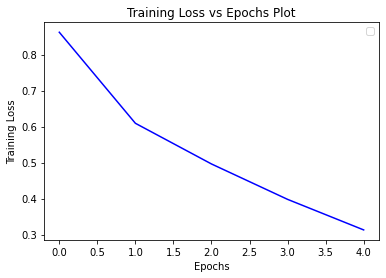

No handles with labels found to put in legend.


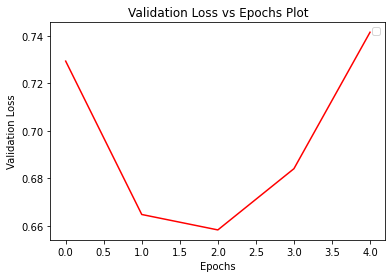

159it [00:00, 615.83it/s]


Accuracy on train: 91.47


23it [00:00, 585.00it/s]


Accuracy on test: 75.00


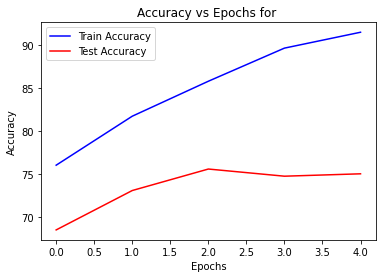

fl score on test: 0.74
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       363
           1       0.77      0.76      0.76       217
           2       0.67      0.43      0.52        82
           3       0.61      0.47      0.53        58

    accuracy                           0.75       720
   macro avg       0.71      0.63      0.66       720
weighted avg       0.74      0.75      0.74       720



In [126]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

## X = 3

In [127]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(4)

15it [00:00, 23.96it/s]

Epoch 1 / 5, Step 10 / 159, Loss: 1.1530


24it [00:01, 23.25it/s]

Epoch 1 / 5, Step 20 / 159, Loss: 1.0150


33it [00:01, 22.34it/s]

Epoch 1 / 5, Step 30 / 159, Loss: 0.9248


42it [00:01, 23.46it/s]

Epoch 1 / 5, Step 40 / 159, Loss: 0.9128


54it [00:02, 22.90it/s]

Epoch 1 / 5, Step 50 / 159, Loss: 0.8993


63it [00:02, 23.70it/s]

Epoch 1 / 5, Step 60 / 159, Loss: 0.8318


72it [00:03, 23.57it/s]

Epoch 1 / 5, Step 70 / 159, Loss: 0.7960


84it [00:03, 23.79it/s]

Epoch 1 / 5, Step 80 / 159, Loss: 0.7155


93it [00:03, 23.44it/s]

Epoch 1 / 5, Step 90 / 159, Loss: 0.6497


102it [00:04, 23.24it/s]

Epoch 1 / 5, Step 100 / 159, Loss: 0.5934


114it [00:04, 23.08it/s]

Epoch 1 / 5, Step 110 / 159, Loss: 0.5190


123it [00:05, 23.30it/s]

Epoch 1 / 5, Step 120 / 159, Loss: 0.5179


132it [00:05, 23.72it/s]

Epoch 1 / 5, Step 130 / 159, Loss: 0.4450


144it [00:06, 23.84it/s]

Epoch 1 / 5, Step 140 / 159, Loss: 0.4384


153it [00:06, 23.27it/s]

Epoch 1 / 5, Step 150 / 159, Loss: 0.4202


159it [00:06, 23.30it/s]
159it [00:00, 519.20it/s]


Accuracy on train: 75.72


23it [00:00, 485.10it/s]


Accuracy on test: 68.85


12it [00:00, 23.43it/s]

Epoch 2 / 5, Step 10 / 159, Loss: 0.3755


24it [00:01, 24.18it/s]

Epoch 2 / 5, Step 20 / 159, Loss: 0.3580


33it [00:01, 23.38it/s]

Epoch 2 / 5, Step 30 / 159, Loss: 0.3333


42it [00:01, 23.02it/s]

Epoch 2 / 5, Step 40 / 159, Loss: 0.3333


54it [00:02, 23.19it/s]

Epoch 2 / 5, Step 50 / 159, Loss: 0.3453


63it [00:02, 22.93it/s]

Epoch 2 / 5, Step 60 / 159, Loss: 0.3294


72it [00:03, 22.40it/s]

Epoch 2 / 5, Step 70 / 159, Loss: 0.3267


84it [00:03, 22.70it/s]

Epoch 2 / 5, Step 80 / 159, Loss: 0.3319


93it [00:04, 22.18it/s]

Epoch 2 / 5, Step 90 / 159, Loss: 0.3280


102it [00:04, 21.87it/s]

Epoch 2 / 5, Step 100 / 159, Loss: 0.3623


114it [00:05, 21.77it/s]

Epoch 2 / 5, Step 110 / 159, Loss: 0.3277


123it [00:05, 22.24it/s]

Epoch 2 / 5, Step 120 / 159, Loss: 0.3770


132it [00:05, 22.41it/s]

Epoch 2 / 5, Step 130 / 159, Loss: 0.3422


144it [00:06, 21.91it/s]

Epoch 2 / 5, Step 140 / 159, Loss: 0.3416


153it [00:06, 22.85it/s]

Epoch 2 / 5, Step 150 / 159, Loss: 0.3630


159it [00:07, 22.65it/s]
159it [00:00, 538.21it/s]


Accuracy on train: 80.72


23it [00:00, 425.58it/s]


Accuracy on test: 74.41


12it [00:00, 23.99it/s]

Epoch 3 / 5, Step 10 / 159, Loss: 0.3190


24it [00:01, 23.01it/s]

Epoch 3 / 5, Step 20 / 159, Loss: 0.3124


33it [00:01, 23.47it/s]

Epoch 3 / 5, Step 30 / 159, Loss: 0.2862


42it [00:01, 23.37it/s]

Epoch 3 / 5, Step 40 / 159, Loss: 0.2770


54it [00:02, 22.82it/s]

Epoch 3 / 5, Step 50 / 159, Loss: 0.2867


63it [00:02, 23.14it/s]

Epoch 3 / 5, Step 60 / 159, Loss: 0.2551


72it [00:03, 22.86it/s]

Epoch 3 / 5, Step 70 / 159, Loss: 0.2596


84it [00:03, 23.64it/s]

Epoch 3 / 5, Step 80 / 159, Loss: 0.2739


93it [00:03, 23.82it/s]

Epoch 3 / 5, Step 90 / 159, Loss: 0.2724


102it [00:04, 23.51it/s]

Epoch 3 / 5, Step 100 / 159, Loss: 0.2969


114it [00:04, 24.49it/s]

Epoch 3 / 5, Step 110 / 159, Loss: 0.2691


123it [00:05, 23.87it/s]

Epoch 3 / 5, Step 120 / 159, Loss: 0.2956


132it [00:05, 23.44it/s]

Epoch 3 / 5, Step 130 / 159, Loss: 0.2945


144it [00:06, 21.71it/s]

Epoch 3 / 5, Step 140 / 159, Loss: 0.2911


153it [00:06, 22.61it/s]

Epoch 3 / 5, Step 150 / 159, Loss: 0.3101


159it [00:06, 23.15it/s]
159it [00:00, 524.40it/s]


Accuracy on train: 84.69


23it [00:00, 470.55it/s]


Accuracy on test: 75.66


12it [00:00, 21.19it/s]

Epoch 4 / 5, Step 10 / 159, Loss: 0.2689


24it [00:01, 21.51it/s]

Epoch 4 / 5, Step 20 / 159, Loss: 0.2555


33it [00:01, 22.68it/s]

Epoch 4 / 5, Step 30 / 159, Loss: 0.2448


42it [00:01, 23.13it/s]

Epoch 4 / 5, Step 40 / 159, Loss: 0.2220


54it [00:02, 23.16it/s]

Epoch 4 / 5, Step 50 / 159, Loss: 0.2406


63it [00:02, 22.69it/s]

Epoch 4 / 5, Step 60 / 159, Loss: 0.2106


72it [00:03, 22.88it/s]

Epoch 4 / 5, Step 70 / 159, Loss: 0.2109


84it [00:03, 23.16it/s]

Epoch 4 / 5, Step 80 / 159, Loss: 0.2282


93it [00:04, 22.43it/s]

Epoch 4 / 5, Step 90 / 159, Loss: 0.2397


102it [00:04, 22.09it/s]

Epoch 4 / 5, Step 100 / 159, Loss: 0.2595


114it [00:05, 22.49it/s]

Epoch 4 / 5, Step 110 / 159, Loss: 0.2281


123it [00:05, 22.12it/s]

Epoch 4 / 5, Step 120 / 159, Loss: 0.2295


132it [00:05, 22.55it/s]

Epoch 4 / 5, Step 130 / 159, Loss: 0.2426


144it [00:06, 22.76it/s]

Epoch 4 / 5, Step 140 / 159, Loss: 0.2563


153it [00:06, 22.73it/s]

Epoch 4 / 5, Step 150 / 159, Loss: 0.2781


159it [00:07, 22.37it/s]
159it [00:00, 505.20it/s]


Accuracy on train: 87.87


23it [00:00, 466.24it/s]


Accuracy on test: 76.08


12it [00:00, 23.52it/s]

Epoch 5 / 5, Step 10 / 159, Loss: 0.2322


24it [00:01, 23.48it/s]

Epoch 5 / 5, Step 20 / 159, Loss: 0.2240


31it [00:02,  9.36it/s]

Epoch 5 / 5, Step 30 / 159, Loss: 0.2207


43it [00:02, 17.91it/s]

Epoch 5 / 5, Step 40 / 159, Loss: 0.2015


52it [00:03, 21.03it/s]

Epoch 5 / 5, Step 50 / 159, Loss: 0.2133


64it [00:03, 21.30it/s]

Epoch 5 / 5, Step 60 / 159, Loss: 0.1904


73it [00:04, 22.90it/s]

Epoch 5 / 5, Step 70 / 159, Loss: 0.1800


82it [00:04, 22.60it/s]

Epoch 5 / 5, Step 80 / 159, Loss: 0.1887


94it [00:04, 23.03it/s]

Epoch 5 / 5, Step 90 / 159, Loss: 0.2054


103it [00:05, 22.72it/s]

Epoch 5 / 5, Step 100 / 159, Loss: 0.2123


112it [00:05, 21.79it/s]

Epoch 5 / 5, Step 110 / 159, Loss: 0.1883


124it [00:06, 21.84it/s]

Epoch 5 / 5, Step 120 / 159, Loss: 0.1736


133it [00:06, 21.57it/s]

Epoch 5 / 5, Step 130 / 159, Loss: 0.1739


142it [00:07, 21.31it/s]

Epoch 5 / 5, Step 140 / 159, Loss: 0.1962


154it [00:07, 20.77it/s]

Epoch 5 / 5, Step 150 / 159, Loss: 0.2396


159it [00:07, 19.93it/s]
159it [00:00, 487.96it/s]


Accuracy on train: 90.51


23it [00:00, 436.21it/s]

Accuracy on test: 74.27
Finished Training


In [128]:
modelSave(lstm,"X3")

No handles with labels found to put in legend.


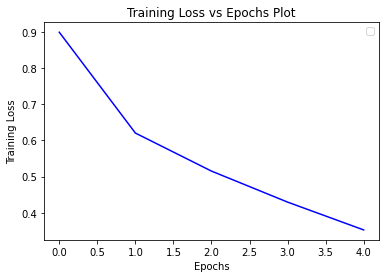

No handles with labels found to put in legend.


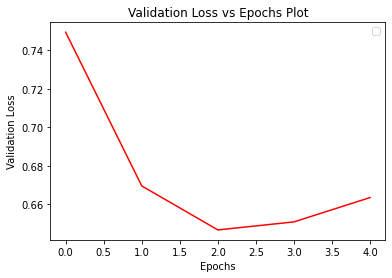

159it [00:00, 552.61it/s]


Accuracy on train: 90.51


23it [00:00, 480.59it/s]


Accuracy on test: 74.27


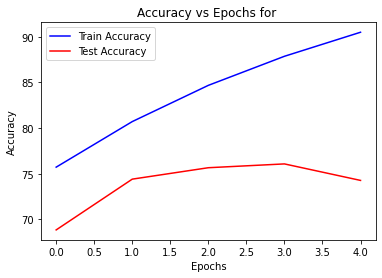

fl score on test: 0.73
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       363
           1       0.75      0.74      0.75       217
           2       0.65      0.38      0.48        81
           3       0.67      0.48      0.56        58

    accuracy                           0.74       719
   macro avg       0.71      0.62      0.65       719
weighted avg       0.74      0.74      0.73       719



In [129]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

## X = 4

In [130]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(5)

14it [00:00, 20.29it/s]

Epoch 1 / 5, Step 10 / 159, Loss: 1.1507


22it [00:01, 20.08it/s]

Epoch 1 / 5, Step 20 / 159, Loss: 1.0105


33it [00:01, 19.38it/s]

Epoch 1 / 5, Step 30 / 159, Loss: 0.9135


43it [00:02, 18.76it/s]

Epoch 1 / 5, Step 40 / 159, Loss: 0.9079


53it [00:02, 18.98it/s]

Epoch 1 / 5, Step 50 / 159, Loss: 0.8556


64it [00:03, 19.47it/s]

Epoch 1 / 5, Step 60 / 159, Loss: 0.7294


72it [00:03, 18.99it/s]

Epoch 1 / 5, Step 70 / 159, Loss: 0.6391


82it [00:04, 18.51it/s]

Epoch 1 / 5, Step 80 / 159, Loss: 0.5302


92it [00:04, 17.89it/s]

Epoch 1 / 5, Step 90 / 159, Loss: 0.4460


103it [00:05, 19.20it/s]

Epoch 1 / 5, Step 100 / 159, Loss: 0.4363


112it [00:05, 19.71it/s]

Epoch 1 / 5, Step 110 / 159, Loss: 0.3958


123it [00:06, 20.58it/s]

Epoch 1 / 5, Step 120 / 159, Loss: 0.4313


132it [00:06, 20.40it/s]

Epoch 1 / 5, Step 130 / 159, Loss: 0.4022


144it [00:07, 20.24it/s]

Epoch 1 / 5, Step 140 / 159, Loss: 0.4392


153it [00:07, 20.32it/s]

Epoch 1 / 5, Step 150 / 159, Loss: 0.4169


159it [00:08, 19.44it/s]
159it [00:00, 422.67it/s]


Accuracy on train: 75.34


23it [00:00, 435.67it/s]


Accuracy on test: 67.27


12it [00:00, 19.86it/s]

Epoch 2 / 5, Step 10 / 159, Loss: 0.3240


23it [00:01, 20.23it/s]

Epoch 2 / 5, Step 20 / 159, Loss: 0.3100


32it [00:01, 20.26it/s]

Epoch 2 / 5, Step 30 / 159, Loss: 0.2524


44it [00:02, 20.43it/s]

Epoch 2 / 5, Step 40 / 159, Loss: 0.2351


53it [00:02, 19.79it/s]

Epoch 2 / 5, Step 50 / 159, Loss: 0.2663


62it [00:03, 19.76it/s]

Epoch 2 / 5, Step 60 / 159, Loss: 0.2884


73it [00:03, 19.88it/s]

Epoch 2 / 5, Step 70 / 159, Loss: 0.2777


83it [00:04, 19.20it/s]

Epoch 2 / 5, Step 80 / 159, Loss: 0.3038


94it [00:04, 19.75it/s]

Epoch 2 / 5, Step 90 / 159, Loss: 0.2712


103it [00:05, 19.81it/s]

Epoch 2 / 5, Step 100 / 159, Loss: 0.2728


114it [00:05, 19.95it/s]

Epoch 2 / 5, Step 110 / 159, Loss: 0.2471


124it [00:06, 20.18it/s]

Epoch 2 / 5, Step 120 / 159, Loss: 0.3493


131it [00:06, 19.15it/s]

Epoch 2 / 5, Step 130 / 159, Loss: 0.3251


142it [00:07, 20.10it/s]

Epoch 2 / 5, Step 140 / 159, Loss: 0.3616


153it [00:07, 19.57it/s]

Epoch 2 / 5, Step 150 / 159, Loss: 0.3540


159it [00:08, 19.76it/s]
159it [00:00, 434.16it/s]


Accuracy on train: 80.16


23it [00:00, 397.92it/s]


Accuracy on test: 72.98


12it [00:00, 19.77it/s]

Epoch 3 / 5, Step 10 / 159, Loss: 0.2434


23it [00:01, 19.67it/s]

Epoch 3 / 5, Step 20 / 159, Loss: 0.2531


33it [00:01, 19.25it/s]

Epoch 3 / 5, Step 30 / 159, Loss: 0.1879


43it [00:02, 19.50it/s]

Epoch 3 / 5, Step 40 / 159, Loss: 0.1605


53it [00:02, 19.08it/s]

Epoch 3 / 5, Step 50 / 159, Loss: 0.1865


62it [00:03, 20.30it/s]

Epoch 3 / 5, Step 60 / 159, Loss: 0.2082


74it [00:03, 20.56it/s]

Epoch 3 / 5, Step 70 / 159, Loss: 0.2171


83it [00:04, 20.91it/s]

Epoch 3 / 5, Step 80 / 159, Loss: 0.2466


92it [00:04, 20.90it/s]

Epoch 3 / 5, Step 90 / 159, Loss: 0.2219


104it [00:05, 20.74it/s]

Epoch 3 / 5, Step 100 / 159, Loss: 0.2112


113it [00:05, 20.93it/s]

Epoch 3 / 5, Step 110 / 159, Loss: 0.1890


122it [00:06, 20.16it/s]

Epoch 3 / 5, Step 120 / 159, Loss: 0.2773


134it [00:06, 20.58it/s]

Epoch 3 / 5, Step 130 / 159, Loss: 0.2712


143it [00:07, 20.43it/s]

Epoch 3 / 5, Step 140 / 159, Loss: 0.3035


152it [00:07, 20.49it/s]

Epoch 3 / 5, Step 150 / 159, Loss: 0.2903


159it [00:07, 20.15it/s]
159it [00:00, 467.57it/s]


Accuracy on train: 84.11


23it [00:00, 386.55it/s]


Accuracy on test: 75.35


12it [00:00, 17.78it/s]

Epoch 4 / 5, Step 10 / 159, Loss: 0.1891


23it [00:01, 19.21it/s]

Epoch 4 / 5, Step 20 / 159, Loss: 0.2197


32it [00:01, 19.55it/s]

Epoch 4 / 5, Step 30 / 159, Loss: 0.1451


42it [00:02, 20.01it/s]

Epoch 4 / 5, Step 40 / 159, Loss: 0.1164


53it [00:02, 19.22it/s]

Epoch 4 / 5, Step 50 / 159, Loss: 0.1338


63it [00:03, 19.32it/s]

Epoch 4 / 5, Step 60 / 159, Loss: 0.1606


74it [00:03, 19.70it/s]

Epoch 4 / 5, Step 70 / 159, Loss: 0.1744


82it [00:04, 19.59it/s]

Epoch 4 / 5, Step 80 / 159, Loss: 0.1955


92it [00:04, 18.98it/s]

Epoch 4 / 5, Step 90 / 159, Loss: 0.1997


102it [00:05, 19.20it/s]

Epoch 4 / 5, Step 100 / 159, Loss: 0.1646


113it [00:05, 19.25it/s]

Epoch 4 / 5, Step 110 / 159, Loss: 0.1396


123it [00:06, 19.08it/s]

Epoch 4 / 5, Step 120 / 159, Loss: 0.2046


132it [00:06, 19.05it/s]

Epoch 4 / 5, Step 130 / 159, Loss: 0.2162


143it [00:07, 19.65it/s]

Epoch 4 / 5, Step 140 / 159, Loss: 0.2686


153it [00:07, 19.98it/s]

Epoch 4 / 5, Step 150 / 159, Loss: 0.2661


159it [00:08, 19.17it/s]
159it [00:00, 448.09it/s]


Accuracy on train: 87.83


23it [00:00, 431.80it/s]


Accuracy on test: 75.77


12it [00:00, 19.49it/s]

Epoch 5 / 5, Step 10 / 159, Loss: 0.1627


24it [00:01, 20.08it/s]

Epoch 5 / 5, Step 20 / 159, Loss: 0.2058


34it [00:01, 20.45it/s]

Epoch 5 / 5, Step 30 / 159, Loss: 0.1357


43it [00:02, 19.74it/s]

Epoch 5 / 5, Step 40 / 159, Loss: 0.1126


54it [00:02, 20.30it/s]

Epoch 5 / 5, Step 50 / 159, Loss: 0.1315


63it [00:03, 20.12it/s]

Epoch 5 / 5, Step 60 / 159, Loss: 0.1306


72it [00:03, 20.44it/s]

Epoch 5 / 5, Step 70 / 159, Loss: 0.1430


83it [00:04, 19.47it/s]

Epoch 5 / 5, Step 80 / 159, Loss: 0.1867


94it [00:04, 20.41it/s]

Epoch 5 / 5, Step 90 / 159, Loss: 0.1830


103it [00:05, 20.44it/s]

Epoch 5 / 5, Step 100 / 159, Loss: 0.1291


112it [00:05, 20.51it/s]

Epoch 5 / 5, Step 110 / 159, Loss: 0.1125


123it [00:06, 19.69it/s]

Epoch 5 / 5, Step 120 / 159, Loss: 0.1571


133it [00:06, 19.22it/s]

Epoch 5 / 5, Step 130 / 159, Loss: 0.1816


144it [00:07, 19.41it/s]

Epoch 5 / 5, Step 140 / 159, Loss: 0.2511


152it [00:07, 18.85it/s]

Epoch 5 / 5, Step 150 / 159, Loss: 0.2801


159it [00:08, 19.72it/s]
159it [00:00, 446.87it/s]


Accuracy on train: 90.17


23it [00:00, 459.65it/s]

Accuracy on test: 75.77
Finished Training


In [131]:
modelSave(lstm,"X4")

No handles with labels found to put in legend.


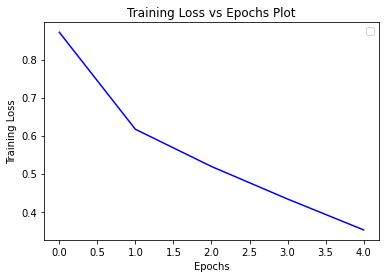

No handles with labels found to put in legend.


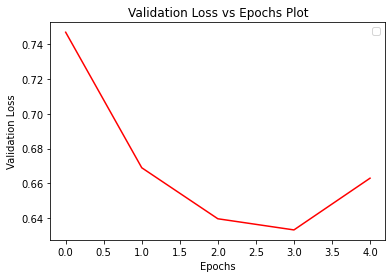

159it [00:00, 436.51it/s]


Accuracy on train: 90.17


23it [00:00, 409.24it/s]


Accuracy on test: 75.77


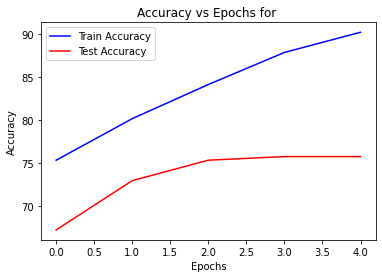

fl score on test: 0.74
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       363
           1       0.77      0.80      0.79       216
           2       0.67      0.43      0.53        81
           3       0.67      0.34      0.45        58

    accuracy                           0.76       718
   macro avg       0.72      0.61      0.65       718
weighted avg       0.75      0.76      0.74       718



In [132]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

In [133]:
def plotForX(data,color,yLabel):
  plt.plot(data, color=color)
  plt.xlabel("X")
  plt.ylabel(yLabel)
  plt.title(yLabel + " vs X ")
  plt.show()

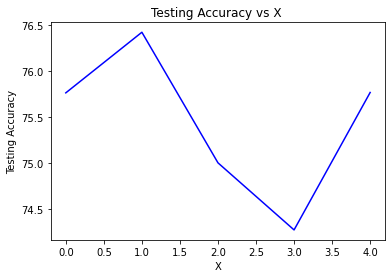

In [134]:
plotForX(X_valacc,"blue","Testing Accuracy")

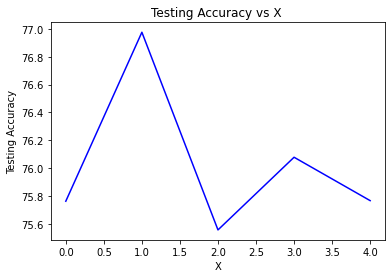

In [135]:
plotForX(X_valMaxacc,"blue","Testing Accuracy")

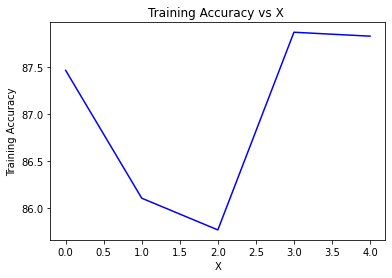

In [136]:
plotForX(X_trainacc,"blue","Training Accuracy")

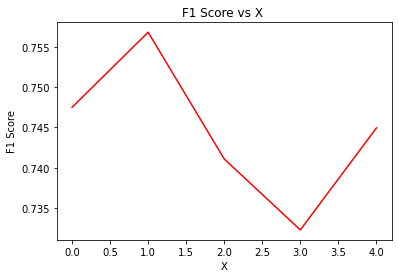

In [137]:
plotForX(X_f1,"red","F1 Score")

Dataloader for taking only previous x utterances (Sliding window --> if x utterances to be considered send x+1 samples at a time (x+1 is window size)) 

### Sentence Embedding for each utterance: Using Glove and then pooling

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# !ls -lat

--2022-04-06 11:10:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-06 11:10:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-06 11:10:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

glove

In [ ]:
vocab,embeddings = [],[]
with open('glove.6B.50d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)




In [ ]:
#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

In [ ]:
max_seq_len = len(max(Xtrain, key=len))

In [ ]:
def convert_text_to_id(df,vocab,unk_token,pad_to_len,pad_token):
  word2idx = {term:idx for idx,term in enumerate(vocab)}
  idx2word = {idx:word for word,idx in word2idx.items()}

  for i in range(len(df)):
    deficit = pad_to_len - len(df[i])
    df[i].extend([pad_token]*deficit)
    for j in range(len(df[i])):
      if df[i][j] not in word2idx:
        df[i][j] = word2idx[unk_token]
      else:
        df[i][j] = word2idx[df[i][j]]
  return df


Xtrain_id = convert_text_to_id(Xtrain,vocab_npa,'<unk>',max_seq_len,'<pad>')

In [ ]:
Xtest_id = convert_text_to_id(Xtest,vocab_npa,'<unk>',max_seq_len,'<pad>')

In [ ]:
class LSTMGloveClass(nn.Module):
    def __init__(self,embs_nps,hidden_size,num_layers,drop_prob):
        super().__init__()
        self.vocab_size = embs_npa.shape[0]
        self.embedding_dim = embs_npa.shape[1]
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(),freeze=True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pool = nn.AdaptiveAvgPool2d((1,self.embedding_dim))
        self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True,bidirectional=False)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_size, 4)
        # self.softmax = nn.Softmax()
        

    def forward(self, x):
      embed_out = self.embedding(x)
      # print("emb",embed_out.shape)
      sentence_embed_out = self.pool(embed_out)
      sentence_embed_out = torch.squeeze(sentence_embed_out,2)
      # print("Senemb",sentence_embed_out.shape)
      hnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      cnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      out,_ = self.lstm(sentence_embed_out,(hnot,cnot))
      out = out[:,-1,:]
      # print("lstm",out.shape)
      out = self.dropout(out)
      out = self.linear(out)
      # print("lin",out.shape)
      # out = self.softmax(out)
      return out

In [ ]:
totalSteps = len(trainDataLoader)
numEpochs = 10
trainLossAll = []
trainAccAll = []
valLossAll = []
valAccAll = []
X = 2  # X previous utterances for t th utterance


for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    trainLoss = 0
    
    for i, data in tqdm(enumerate(trainDataLoader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        # print("l",labels.shape)
        # print(labels)
        labels = labels.reshape((-1,)).to(device)
        # print("l",labels.shape)
        # print(labels)
        # inputs = torch.squeeze(inputs,0)
        # print(inputs.shape)
        # print(inputs)
        # print(inputs.float().shape)
        outputs = lstm(inputs.float())
        
          
        # outputs = torch.squeeze(outputs)
        # outputs = outputs.reshape((-1, 1))
        # print(outputs.shape)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()*inputs.size(0)
    
        lstm.eval()
        validLoss = 0
        for data, target in testDataLoader:
            data, target = data.to(device), target.to(device)
            data = torch.unsqueeze(data,1)
            # print(data.shape)
            output = lstm(data)
            # print(target)
            loss = criterion(output, target)
            validLoss += loss.item()*data.size(0)
        
  

    
        if (i+1) % 10 == 0:
            print(f'Epoch {epoch + 1} / {numEpochs}, Step {i+1} / {totalSteps}, Loss: {loss.item():.4f}')
            # print(outputs)

    trainLoss = trainLoss/len(trainDataLoader.dataset)
    validLoss = validLoss/len(testDataLoader.dataset)
        
    trainAcc,f1Train = AccReport(trainDataLoader,False)
    trainLossAll.append(trainLoss)
    trainAccAll.append(trainAcc)
    valAcc,f1Val = AccReport(testDataLoader,True)
    valLossAll.append(validLoss)
    valAccAll.append(valAcc)


print('Finished Training')

In [ ]:
X_acc_glove = []
X_f1_glove = []

# X = 0

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)

# X = 1

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)

# X = 2

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)

# X = 3

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)

# X = 4

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)